In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
public = pd.read_csv('./ready/public_media_vaccine.csv', encoding='utf-8-sig')
civil = pd.read_csv('./ready/civil_platform_vaccine.csv', encoding='utf-8-sig')

emotion_groups_ekman = {
    'happiness': ['joy', 'amusement', 'excitement', 'pride', 'gratitude', 'relief', 'love', 'caring'],
    'sadness': ['sadness', 'disappointment', 'remorse', 'grief'],
    'anger': ['anger', 'annoyance', 'disapproval'],
    'fear': ['fear', 'nervousness'],
    'disgust': ['disgust', 'embarrassment'],
    'surprise': ['surprise', 'realization', 'confusion'],
}

def process_platform_emotions(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=[date_col])
    df['week'] = df[date_col].dt.to_period('W').apply(lambda r: r.start_time)

    for group, emotions in emotion_groups_ekman.items():
        df[group] = df[emotions].mean(axis=1)

    weekly_df = df.groupby('week')[list(emotion_groups_ekman.keys())].mean().reset_index()
    return weekly_df

weekly_public = process_platform_emotions(public, 'pub_date')
weekly_civil = process_platform_emotions(civil, 'pub_date')

emotion_groups = ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']

# Granger Causality

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. 데이터 준비 ---
df_public_renamed = weekly_public[emotion_groups].add_suffix('_public')
df_civil_renamed = weekly_civil[emotion_groups].add_suffix('_civil')

if 'week' in weekly_public.columns:
    df_public_renamed.index = weekly_public['week']
if 'week' in weekly_civil.columns:
    df_civil_renamed.index = weekly_civil['week']

df_merged = pd.merge(df_public_renamed, df_civil_renamed, left_index=True, right_index=True).dropna()

# --- 2. Granger 인과관계 분석 (시차 1-4) ---
results = []
max_lag_to_test = 4
columns = df_merged.columns

for cause_col in columns:
    for effect_col in columns:
        if cause_col == effect_col:
            continue

        # ### 오류 수정: maxlag 인자를 리스트가 아닌 정수로 전달 ###
        test_result = grangercausalitytests(df_merged[[effect_col, cause_col]], max_lag_to_test, verbose=False)

        # 각 시차별 p-value를 결과 리스트에 저장
        for lag in range(1, max_lag_to_test + 1):
            p_value = test_result[lag][0]['ssr_ftest'][1]
            results.append({
                "Cause": cause_col.replace('_', ' ').title(),
                "Effect": effect_col.replace('_', ' ').title(),
                "Lag": lag,
                "p_value": p_value
            })

# 최종 결과 데이터프레임 생성
granger_results_df = pd.DataFrame(results)

print("[Granger Causality p-values (Lag 1-4)]")
print(granger_results_df.head())

[Granger Causality p-values (Lag 1-4)]
              Cause          Effect  Lag   p_value
0  Happiness Public  Sadness Public    1  0.045464
1  Happiness Public  Sadness Public    2  0.080931
2  Happiness Public  Sadness Public    3  0.049286
3  Happiness Public  Sadness Public    4  0.002640
4  Happiness Public    Anger Public    1  0.264802


In [4]:
# 원본 데이터프레임을 시차(Lag) 순으로 정렬하는 것이 중요합니다.
df_sorted = granger_results_df.sort_values(by=['Cause', 'Effect', 'Lag']).copy()

# 1. p-value가 유의수준(0.05)보다 낮은지 여부를 boolean 값으로 저장
df_sorted['is_significant'] = df_sorted['p_value'] < 0.05

# 2. Cause-Effect 그룹 내에서 이전 시차의 유의미성(is_significant) 값을 가져옴
df_sorted['prev_significant'] = df_sorted.groupby(['Cause', 'Effect'])['is_significant'].shift(1)
# 2-1. Cause-Effect 그룹 내에서 다음 시차의 유의미성(is_significant) 값을 가져옴
df_sorted['next_significant'] = df_sorted.groupby(['Cause', 'Effect'])['is_significant'].shift(-1)


# 3. 연속 유의성을 만족하는 행을 필터링
# 조건: 현재 시차가 유의미하고 AND (이전 시차가 유의미했거나 OR 다음 시차가 유의미할 경우)
consecutive_mask = (df_sorted['is_significant'] & (df_sorted['prev_significant'] | df_sorted['next_significant']))

consecutive_significant_df = df_sorted[consecutive_mask].copy()


# --- 최종 테이블 생성 ---
# 유의수준 별표 추가 함수
def assign_significance(p_value):
    if p_value < 0.001: return '***'
    if p_value < 0.01: return '**'
    if p_value < 0.05: return '*'
    return ''

# 결과 정리
consecutive_significant_df['Significance'] = consecutive_significant_df['p_value'].apply(assign_significance)
consecutive_significant_df['p_value'] = consecutive_significant_df['p_value'].map('{:.4f}'.format)

# 최종 결과 테이블 선택 및 출력
final_consecutive_table = consecutive_significant_df[['Cause', 'Effect', 'Lag', 'p_value', 'Significance']]
#final_consecutive_table.to_csv('granger_summary_table.csv', index=False)


#################
# 1. Lag와 Significance를 합친 새로운 열 'lag_with_stars' 생성
df_to_compress = final_consecutive_table.copy()
df_to_compress['lag_with_stars'] = df_to_compress['Lag'].astype(str) + df_to_compress['Significance']

# 2. Cause와 Effect로 그룹화하고, 'lag_with_stars' 열을 쉼표로 연결하여 압축
compressed_table = df_to_compress.groupby(['Cause', 'Effect'])['lag_with_stars'].apply(', '.join).reset_index()

# 3. 결과 열의 이름을 더 명확하게 변경
compressed_table.rename(columns={'lag_with_stars': 'Lags (Significance)'}, inplace=True)


# --- 최종 압축 테이블 출력 ---
print("[Compressed Table of Consecutive Significance]")
print(compressed_table)


compressed_table.to_csv('granger_summary_compressed_table.csv', index=False)

[Compressed Table of Consecutive Significance]
               Cause            Effect Lags (Significance)
0        Anger Civil   Happiness Civil           3***, 4**
1       Anger Public       Fear Public              2*, 3*
2       Anger Public   Happiness Civil     2***, 3**, 4***
3       Anger Public   Surprise Public          3***, 4***
4      Disgust Civil   Happiness Civil        2**, 3**, 4*
5     Disgust Public    Surprise Civil              2*, 3*
6         Fear Civil       Fear Public              2*, 3*
7        Fear Public        Fear Civil              2*, 3*
8        Fear Public  Happiness Public              3*, 4*
9        Fear Public     Sadness Civil          2*, 3*, 4*
10   Happiness Civil        Fear Civil             3*, 4**
11  Happiness Public     Sadness Civil          2*, 3*, 4*
12  Happiness Public    Sadness Public             3*, 4**
13     Sadness Civil   Surprise Public       2**, 3**, 4**
14    Sadness Public       Fear Public        2**, 3**, 4*
15    Sad

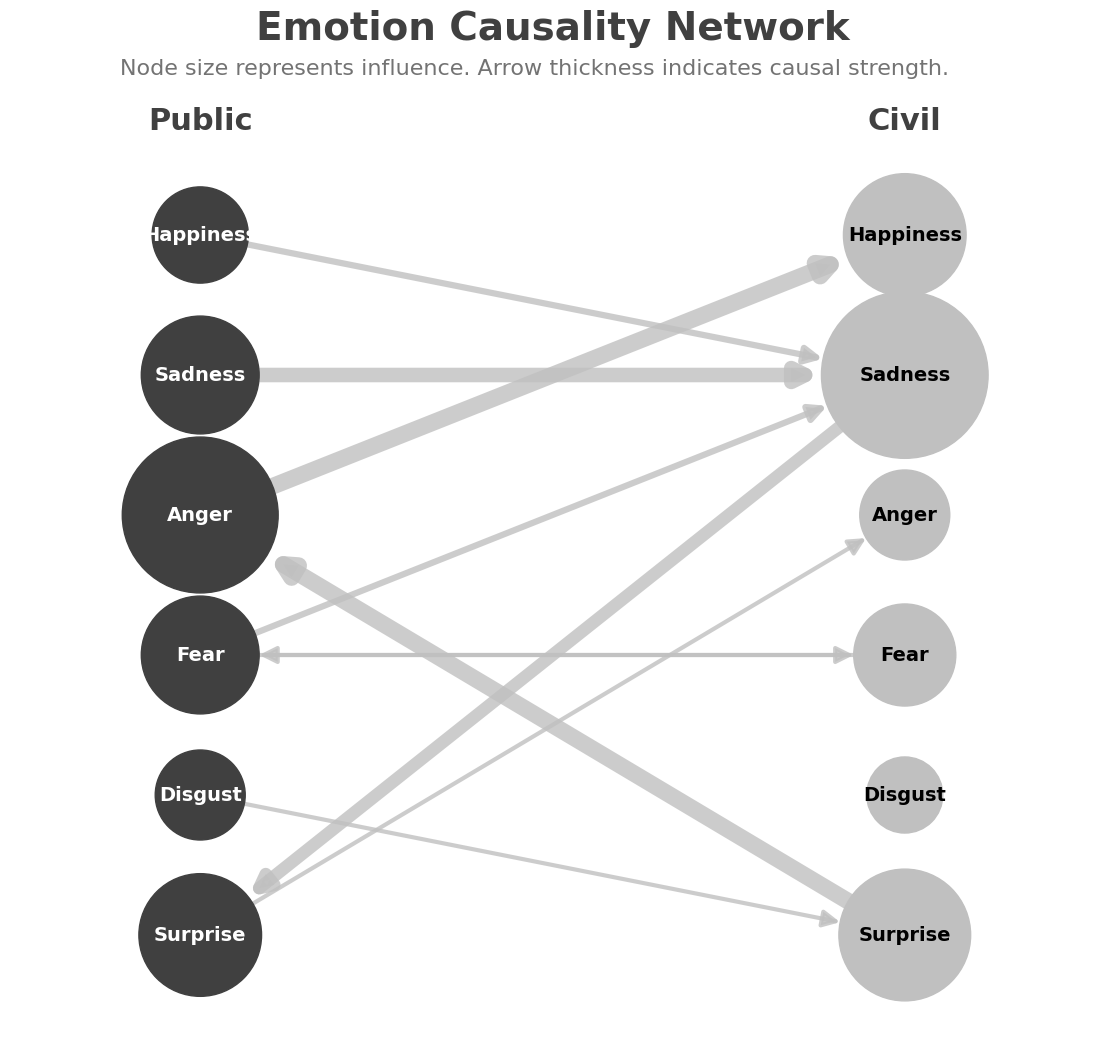

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ✨ [스타일 변경] 깔끔한 산세리프(sans-serif) 글꼴로 전역 설정
plt.rcParams['font.family'] = 'sans-serif'

# 1. 데이터 준비 (기존과 동일)
data = {
    "Cause": ["Happiness Public", "Sadness Public", "Anger Public", "Fear Public", "Fear Public", "Disgust Public", "Surprise Public", "Fear Civil", "Sadness Civil", "Surprise Civil"],
    "Effect": ["Sadness Civil", "Sadness Civil", "Happiness Civil", "Fear Civil", "Sadness Civil", "Surprise Civil", "Anger Civil", "Fear Public", "Surprise Public", "Anger Public"],
    "Lags (Significance)": ["2*, 3*, 4*", "2***, 3**, 4**", "2***, 3**, 4***", "2*, 3*", "2*, 3*, 4*", "2*, 3*", "3*, 4*", "2*, 3*", "2**, 3**, 4**", "2***, 3**, 4***"]
}
df = pd.DataFrame(data)
df['strength'] = df['Lags (Significance)'].apply(lambda x: x.count('*'))

# 2. 그래프 생성 및 노드/레이블 준비 (기존과 동일)
G = nx.from_pandas_edgelist(df, 'Cause', 'Effect',
                            edge_attr=['strength'],
                            create_using=nx.DiGraph())
emotion_order = ['Happiness', 'Sadness', 'Anger', 'Fear', 'Disgust', 'Surprise']
if 'Disgust Civil' not in G.nodes():
    G.add_node('Disgust Civil')
simple_labels = {node: node.split(' ')[0] for node in G.nodes()}

# 3. 노드 크기 및 위치 계산 (기존과 동일)
node_strengths = {node: G.in_degree(node, weight='strength') + G.out_degree(node, weight='strength') for node in G.nodes()}
base_node_size = 3000
node_sizes = [base_node_size + node_strengths.get(node, 0) * 600 for node in G.nodes()]
pos = {}
public_nodes_ordered = [f'{emotion} Public' for emotion in emotion_order]
civil_nodes_ordered = [f'{emotion} Civil' for emotion in emotion_order]
X_PUBLIC, X_CIVIL = -0.8, 0.8
Y_SPACING = 2.0
for i, node in enumerate(public_nodes_ordered):
    pos[node] = (X_PUBLIC, (len(emotion_order) - 1) / 2 * Y_SPACING - i * Y_SPACING)
for i, node in enumerate(civil_nodes_ordered):
    pos[node] = (X_CIVIL, (len(emotion_order) - 1) / 2 * Y_SPACING - i * Y_SPACING)

# 4. 시각화 그리기
fig, ax = plt.subplots(figsize=(14, 12))
fig.set_facecolor('white')

# ✨ [스타일 변경] 차분한 무채색 계열의 색상 팔레트 정의
DARK_GRAY = '#404040'   # 진한 회색
LIGHT_GRAY = '#C0C0C0'  # 밝은 회색
ARROW_COLOR = '#C0C0C0' # 화살표 색상

node_colors = [DARK_GRAY if 'Public' in node else LIGHT_GRAY for node in G.nodes()]

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)

# ✨ [스타일 변경] 노드 색에 따라 텍스트 색상을 다르게 설정 (테두리 효과 제거)
for node, label in simple_labels.items():
    x, y = pos[node]
    # Public(진한회색) 노드는 흰색 텍스트, Civil(밝은회색) 노드는 검은색 텍스트
    text_color = 'white' if 'Public' in node else 'black'
    ax.text(x, y, label,
            ha='center', va='center',
            fontdict={'family': 'sans-serif', 'size': 14, 'weight': 'bold', 'color': text_color})

# 엣지(화살표) 그리기
edge_widths = [d['strength'] * 1.5 for u, v, d in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.8, edge_color=ARROW_COLOR, # ✨ 화살표 색상 변경
                      arrowsize=25, arrowstyle='-|>',
                      node_size=node_sizes, ax=ax)

# 5. 최종 꾸미기
y_top = pos[public_nodes_ordered[0]][1]
ax.text(X_PUBLIC, y_top + 1.5, 'Public', ha='center', fontsize=22, fontweight='bold', color=DARK_GRAY)
ax.text(X_CIVIL, y_top + 1.5, 'Civil', ha='center', fontsize=22, fontweight='bold', color=DARK_GRAY)
ax.set_title("Emotion Causality Network", fontsize=28, fontweight='bold', pad=60, color=DARK_GRAY)
plt.figtext(0.5, 0.92,
            "Node size represents influence. Arrow thickness indicates causal strength.",
            ha="center", fontsize=16, color='#737373') # 부제목 색상도 조정
ax.margins(x=0.2, y=0.1)
ax.axis('off')

plt.show()

C:\Users\LBaDos\AppData\Local\Temp\ipykernel_42736\2076347491.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.95]) # rect로 suptitle과 note 공간 확보


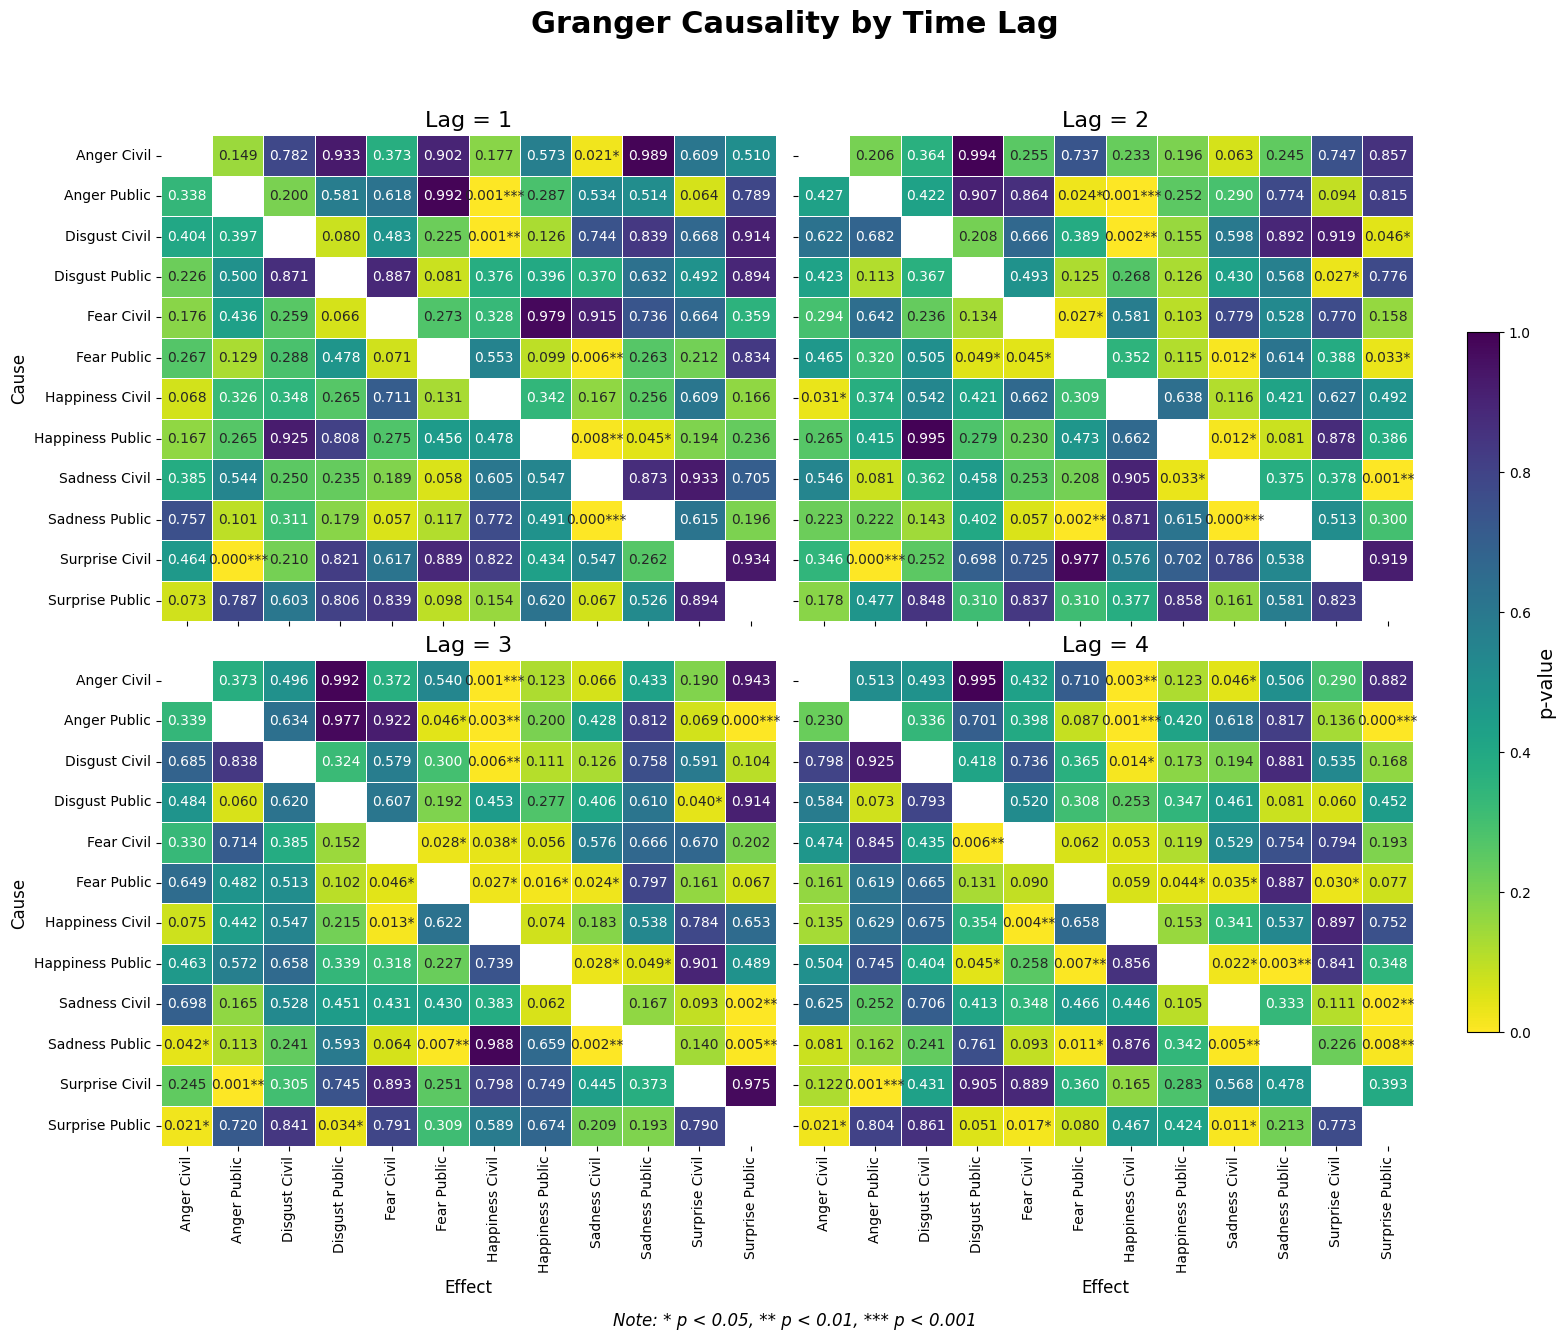

In [6]:
# --- 3. 개선된 시각화 코드 ---
lags = sorted(granger_results_df['Lag'].unique())

# 2x2 그리드 Figure 생성
fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True, sharey=True)
axes = axes.flatten() # 2D 배열을 1D로 변환하여 쉽게 반복

# 전체 Figure의 주 제목 설정
fig.suptitle('Granger Causality by Time Lag', fontsize=22, fontweight='bold')

# p-value 값에 따라 별표를 추가하는 함수
def format_p_value(p):
    if p < 0.001:
        return f'{p:.3f}***'
    elif p < 0.01:
        return f'{p:.3f}**'
    elif p < 0.05:
        return f'{p:.3f}*'
    else:
        return f'{p:.3f}'

# 각 Lag에 대해 Heatmap 그리기
for i, lag in enumerate(lags):
    ax = axes[i]
    df_lag = granger_results_df[granger_results_df['Lag'] == lag]
    
    # Pivot 테이블 생성
    p_value_pivot = df_lag.pivot(index="Cause", columns="Effect", values="p_value")

    # 주석(annotation)용 데이터프레임 생성
    annot_df = p_value_pivot.applymap(format_p_value)

    # Heatmap 그리기
    sns.heatmap(p_value_pivot,
                annot=annot_df,       # p-value와 별표가 포함된 주석 사용
                fmt='',               # annot이 이미 문자열이므로 fmt는 비워둠
                cmap='viridis_r',     # p-value가 낮을수록 진한 색상
                linewidths=.5,
                cbar=False,           # 각 plot의 colorbar는 그리지 않음
                ax=ax,
                vmin=0, vmax=1)       # 모든 plot의 색상 기준을 통일

    ax.set_title(f'Lag = {lag}', fontsize=16)
    
    # x, y 축 레이블 정리
    ax.set_ylabel('Cause' if i % 2 == 0 else '', fontsize=12) # 왼쪽 열에만 Y축 레이블 표시
    ax.set_xlabel('Effect' if i >= 2 else '', fontsize=12) # 아래 행에만 X축 레이블 표시
    ax.tick_params(axis='x', rotation=90)


# 통합 Color Bar 생성
# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
mapper = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=1))
mapper.set_array([])
cbar = plt.colorbar(mapper, cax=cbar_ax)
cbar.set_label('p-value', size=14)

# 유의수준 별표에 대한 설명 추가
fig.text(0.5, 0.04, 'Note: * p < 0.05, ** p < 0.01, *** p < 0.001', 
         ha='center', fontsize=12, style='italic')

# 레이아웃 최적화
plt.tight_layout(rect=[0, 0.05, 0.9, 0.95]) # rect로 suptitle과 note 공간 확보
plt.show()

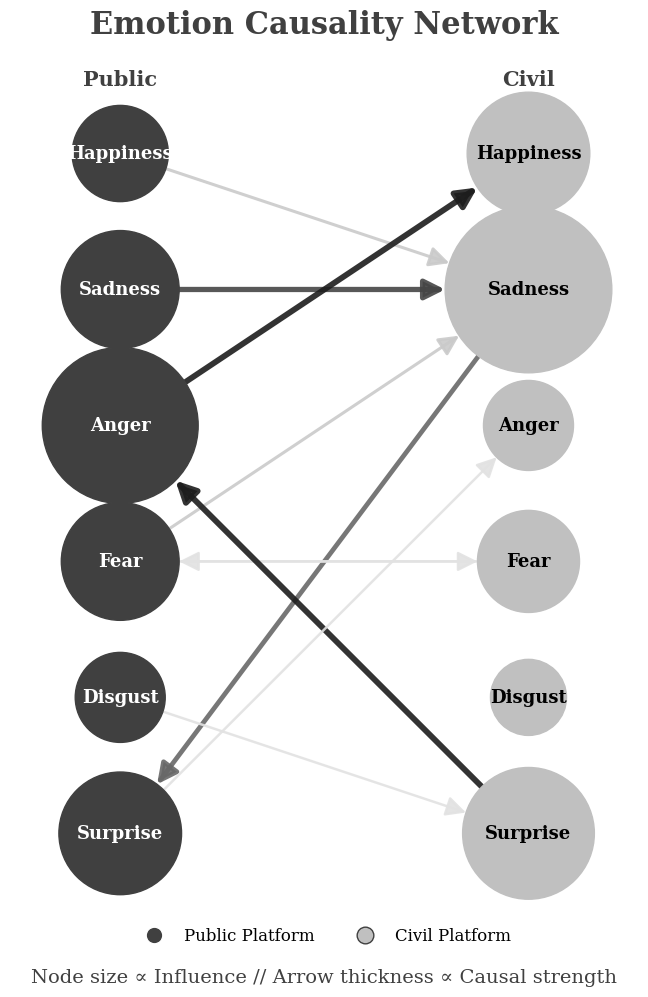

In [45]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# 1. 스타일 통합 설정
class GraphStyle:
    FONT_FAMILY = 'serif'
    TITLE_FONT_SIZE = 22
    COLUMN_HEADER_FONT_SIZE = 15
    NODE_LABEL_FONT_SIZE = 13
    LEGEND_FONT_SIZE = 12
    PUBLIC_COLOR = '#404040'
    CIVIL_COLOR = '#C0C0C0'
    ARROW_COLOR_MAP = 'Greys'
    FIG_SIZE = (7, 10)
    X_POSITIONS = (-0.5, 0.5)
    Y_SPACING = 2.0
    BASE_NODE_SIZE = 3000
    NODE_SIZE_MULTIPLIER = 600
    EDGE_BASE_WIDTH = 1.0
    EDGE_WIDTH_MULTIPLIER = 0.4
    ARROW_SIZE = 30

# 스타일 적용
plt.rcParams['font.family'] = GraphStyle.FONT_FAMILY

# 2. 데이터 준비
data = {
    "Cause": ["Happiness Public", "Sadness Public", "Anger Public", "Fear Public", "Fear Public", "Disgust Public", "Surprise Public", "Fear Civil", "Sadness Civil", "Surprise Civil"],
    "Effect": ["Sadness Civil", "Sadness Civil", "Happiness Civil", "Fear Civil", "Sadness Civil", "Surprise Civil", "Anger Civil", "Fear Public", "Surprise Public", "Anger Public"],
    "Lags (Significance)": ["2*, 3*, 4*", "2***, 3**, 4**", "2***, 3**, 4***", "2*, 3*", "2*, 3*, 4*", "2*, 3*", "3*, 4*", "2*, 3*", "2**, 3**, 4**", "2***, 3**, 4***"]
}
df = pd.DataFrame(data)
df['strength'] = df['Lags (Significance)'].apply(lambda x: x.count('*'))

# 3. 그래프 객체 생성
G = nx.from_pandas_edgelist(df, 'Cause', 'Effect', edge_attr=['strength'], create_using=nx.DiGraph())
emotion_order = ['Happiness', 'Sadness', 'Anger', 'Fear', 'Disgust', 'Surprise']
if 'Disgust Civil' not in G.nodes(): G.add_node('Disgust Civil')
simple_labels = {node: node.split(' ')[0] for node in G.nodes()}

# 4. 노드 크기 및 위치 계산
node_strengths = {node: G.in_degree(node, weight='strength') + G.out_degree(node, weight='strength') for node in G.nodes()}
node_sizes = [GraphStyle.BASE_NODE_SIZE + node_strengths.get(n, 0) * GraphStyle.NODE_SIZE_MULTIPLIER for n in G.nodes()]

pos = {}
X_PUBLIC, X_CIVIL = GraphStyle.X_POSITIONS
for i, node in enumerate([f'{e} Public' for e in emotion_order]):
    pos[node] = (X_PUBLIC, (len(emotion_order) - 1) / 2 * GraphStyle.Y_SPACING - i * GraphStyle.Y_SPACING)
for i, node in enumerate([f'{e} Civil' for e in emotion_order]):
    pos[node] = (X_CIVIL, (len(emotion_order) - 1) / 2 * GraphStyle.Y_SPACING - i * GraphStyle.Y_SPACING)

# 5. 시각화 구현
fig, ax = plt.subplots(figsize=GraphStyle.FIG_SIZE)
fig.set_facecolor('white')

# 노드, 엣지, 텍스트 그리기
node_colors = [GraphStyle.PUBLIC_COLOR if 'Public' in n else GraphStyle.CIVIL_COLOR for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)
strengths = [d['strength'] for u, v, d in G.edges(data=True)]
edge_widths = [GraphStyle.EDGE_BASE_WIDTH + (s * GraphStyle.EDGE_WIDTH_MULTIPLIER) for s in strengths]
norm = mcolors.Normalize(vmin=min(strengths), vmax=max(strengths))
cmap = plt.get_cmap(GraphStyle.ARROW_COLOR_MAP)
edge_colors = [cmap(norm(s) * 0.7 + 0.2) for s in strengths]
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors,
                      alpha=0.9, arrowsize=GraphStyle.ARROW_SIZE, arrowstyle='-|>', node_size=node_sizes, ax=ax)
for node, label in simple_labels.items():
    x, y = pos[node]
    text_color = 'white' if 'Public' in node else 'black'
    ax.text(x, y, label, ha='center', va='center',
            fontdict={'family': GraphStyle.FONT_FAMILY, 'size': GraphStyle.NODE_LABEL_FONT_SIZE, 'weight': 'bold', 'color': text_color})

# 6. 제목 및 범례
y_top = pos[f'{emotion_order[0]} Public'][1]
ax.text(X_PUBLIC, y_top + 1.0, 'Public', ha='center', fontsize=GraphStyle.COLUMN_HEADER_FONT_SIZE, fontweight='bold', color=GraphStyle.PUBLIC_COLOR)
ax.text(X_CIVIL, y_top + 1.0, 'Civil', ha='center', fontsize=GraphStyle.COLUMN_HEADER_FONT_SIZE, fontweight='bold', color=GraphStyle.PUBLIC_COLOR)
ax.set_title("Emotion Causality Network", fontsize=GraphStyle.TITLE_FONT_SIZE, fontweight='bold', pad=35, color=GraphStyle.PUBLIC_COLOR)


ax.text(0.5,          # x축 50% (가운데)
        -0.1,         # y축 100% 위에 살짝(2%) 올라간 위치
        'Node size ∝ Influence // Arrow thickness ∝ Causal strength',
        transform=ax.transAxes,   # axes 기준 좌표계
        ha='center', va='bottom',
        fontsize=14,
        color=GraphStyle.PUBLIC_COLOR)



legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Public Platform', markerfacecolor=GraphStyle.PUBLIC_COLOR, markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Civil Platform', markerfacecolor=GraphStyle.CIVIL_COLOR, markersize=12, markeredgecolor=GraphStyle.PUBLIC_COLOR)
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01),
          ncol=2, frameon=False, fontsize=GraphStyle.LEGEND_FONT_SIZE)

# 7. 최종 레이아웃 및 저장
ax.axis('off')

ax.margins(x=0.2)

# 1. 1차 자동 레이아웃 조정
fig.tight_layout(pad=1.0)

# 2. 캔버스 강제 렌더링으로 모든 요소 위치 확정 (가장 중요)
fig.canvas.draw()

# 3. 확정된 영역을 기준으로 모든 요소를 포함하여 저장
plt.savefig('Figure 5. Emotion Causality Network.svg', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.savefig('Figure 5. Emotion Causality Network.pdf', dpi=300, bbox_inches='tight', pad_inches=0.2)
# plt.show()